<a href="https://colab.research.google.com/github/letrongminh/Torch4GANs/blob/main/Transformer_05_Darts_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install darts

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset, TemperatureDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [4]:
from darts.models import TransformerModel, ExponentialSmoothing
from darts.datasets import SunspotsDataset
from sklearn.model_selection import train_test_split

# Prepare data

In [47]:
df = pd.read_csv('/content/mini_co2.csv')
#df_train, df_test = train_test_split(df, test_size=0.15)
#df['timestamp'] = df[['timestamp']].apply(lambda x: x[0], axis=1).astype(str)
#print(df.ts)
# df = df.astype(np.float32)
print(df.shape)

(2768, 2)


In [48]:
df['ts'] = df['ts'].astype('datetime64[ns]')
#df_train['ts'] = df_train['ts'].astype('datetime64[ns]')
#df_test['ts'] = df_test['ts'].astype('datetime64[ns]')

In [83]:
# if the source is a dataframe: create a time series object from a dataframe's column
# co2, temperature, humidity, pm25, pm10
ts = TimeSeries.from_series(df["co2"])
#ts_train = TimeSeries.from_series(df_train["pm25"])
#ts_test = TimeSeries.from_series(df_test["pm25"])

#ts_train, ts_test = ts.split_before(0.92)
ts_train, ts_test = ts[:-240], ts[-240:]
print("ts: ", ts, "ts_train: ", ts_train, "ts_test: ", ts_test)

ts:  <TimeSeries (DataArray) (time: 2768, component: 1, sample: 1)>
array([[[ 708.]],

       [[ 694.]],

       [[ 693.]],

       ...,

       [[1369.]],

       [[1360.]],

       [[1355.]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2761 2762 2763 2764 2765 2766 2767
  * component  (component) object 'co2'
Dimensions without coordinates: sample ts_train:  <TimeSeries (DataArray) (time: 2528, component: 1, sample: 1)>
array([[[ 708.]],

       [[ 694.]],

       [[ 693.]],

       ...,

       [[ 988.]],

       [[1004.]],

       [[ 985.]]])
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 ... 2521 2522 2523 2524 2525 2526 2527
  * component  (component) object 'co2'
Dimensions without coordinates: sample ts_test:  <TimeSeries (DataArray) (time: 240, component: 1, sample: 1)>
array([[[1040.]],

       [[1067.]],

       [[1081.]],

       [[1180.]],

       [[1195.]],

       [[1228.]],

       [[1225.]],

       [[1242.]],

       [[1221.]],

       [[1228.]

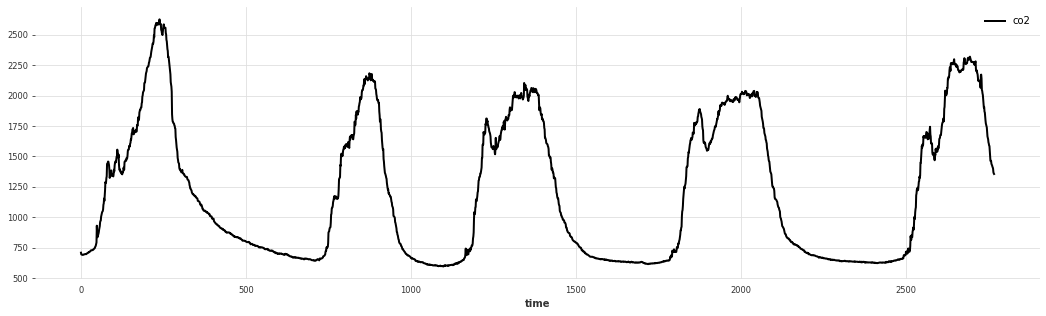

In [84]:
# plot the observations
plt.figure(figsize=(18, 5))
ts.plot()

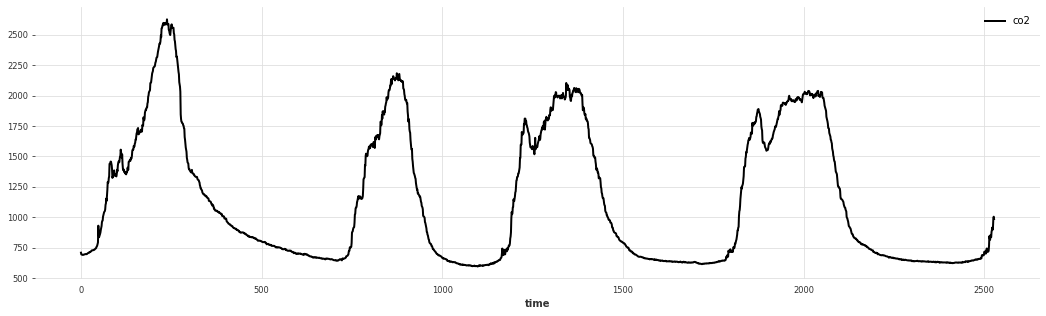

In [85]:
plt.figure(figsize=(18, 5))
ts_train.plot()

In [86]:
scaler = Scaler()

train_scaled = scaler.fit_transform(ts_train)
val_scaled = scaler.transform(ts_test)
ts_scaled = scaler.transform(ts)

In [87]:
print(len(train_scaled), len(val_scaled), len(ts_scaled))
print("the CO2 dataset has {} data points".format(len(ts)))

2528 240 2768
the CO2 dataset has 2768 data points


# Build model

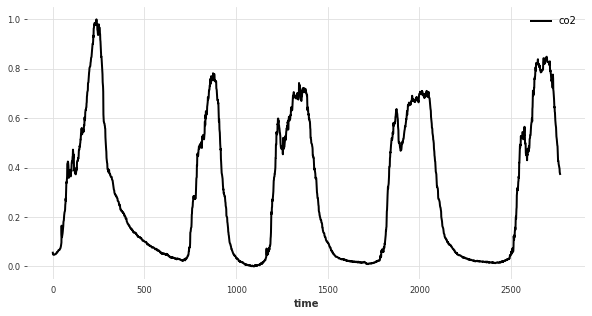

In [88]:
plt.figure(figsize=(10, 5))
ts_scaled.plot()

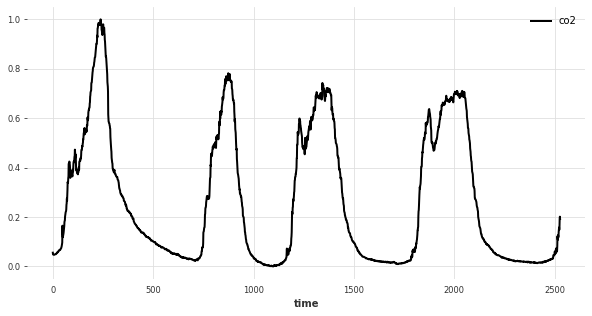

In [89]:
plt.figure(figsize=(10, 5))
train_scaled.plot()

In [92]:
my_model_ = TransformerModel(
    batch_size=16,
    input_chunk_length=180,
    output_chunk_length=30,
    n_epochs=100,
    model_name="transformer_training",
    nr_epochs_val_period=5,
    d_model=16,
    nhead=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    random_state=42,
    optimizer_kwargs={"lr": 1e-3},
    save_checkpoints=True,
    force_reset=True,
    add_encoders={
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['absolute'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}
)

In [93]:
my_model_.fit(series=train_scaled, val_series=val_scaled, verbose=True)

  1%|          | 1/100 [00:04<07:05,  4.29s/it]

  6%|▌         | 6/100 [00:24<06:25,  4.10s/it]

 11%|█         | 11/100 [00:45<06:05,  4.10s/it]

 16%|█▌        | 16/100 [01:05<05:42,  4.08s/it]

 21%|██        | 21/100 [01:26<05:23,  4.09s/it]

 26%|██▌       | 26/100 [01:46<05:03,  4.10s/it]

 31%|███       | 31/100 [02:06<04:41,  4.08s/it]

 36%|███▌      | 36/100 [02:27<04:20,  4.07s/it]

 41%|████      | 41/100 [02:47<04:00,  4.07s/it]

 46%|████▌     | 46/100 [03:07<03:39,  4.07s/it]

 51%|█████     | 51/100 [03:28<03:19,  4.07s/it]

 56%|█████▌    | 56/100 [03:48<02:58,  4.06s/it]

 61%|██████    | 61/100 [04:08<02:38,  4.06s/it]

 66%|██████▌   | 66/100 [04:29<02:18,  4.07s/it]

 71%|███████   | 71/100 [04:49<01:58,  4.07s/it]

 76%|███████▌  | 76/100 [05:09<01:37,  4.07s/it]

 81%|████████  | 81/100 [05:30<01:17,  4.07s/it]

 86%|████████▌ | 86/100 [05:50<00:56,  4.07s/it]

 91%|█████████ | 91/100 [06:10<00:36,  4.06s/it]

 96%|█████████▌| 96/100 [06:31<00:16,  4.07s/it]

100%|██████████| 100/100 [06:47<00:00,  4.07s/it]


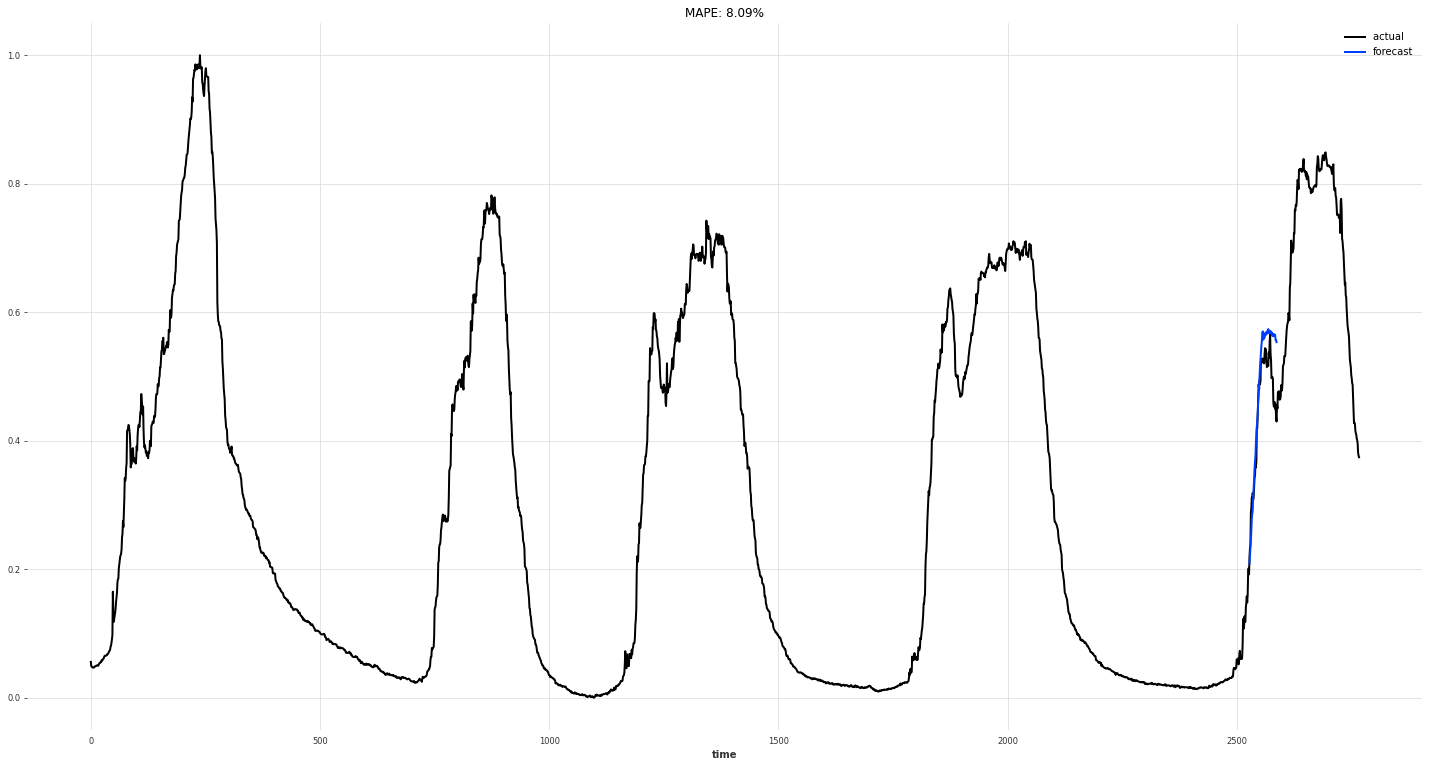

In [111]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series.plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('1.png')


eval_model(my_model_, 60, ts_scaled, val_scaled)

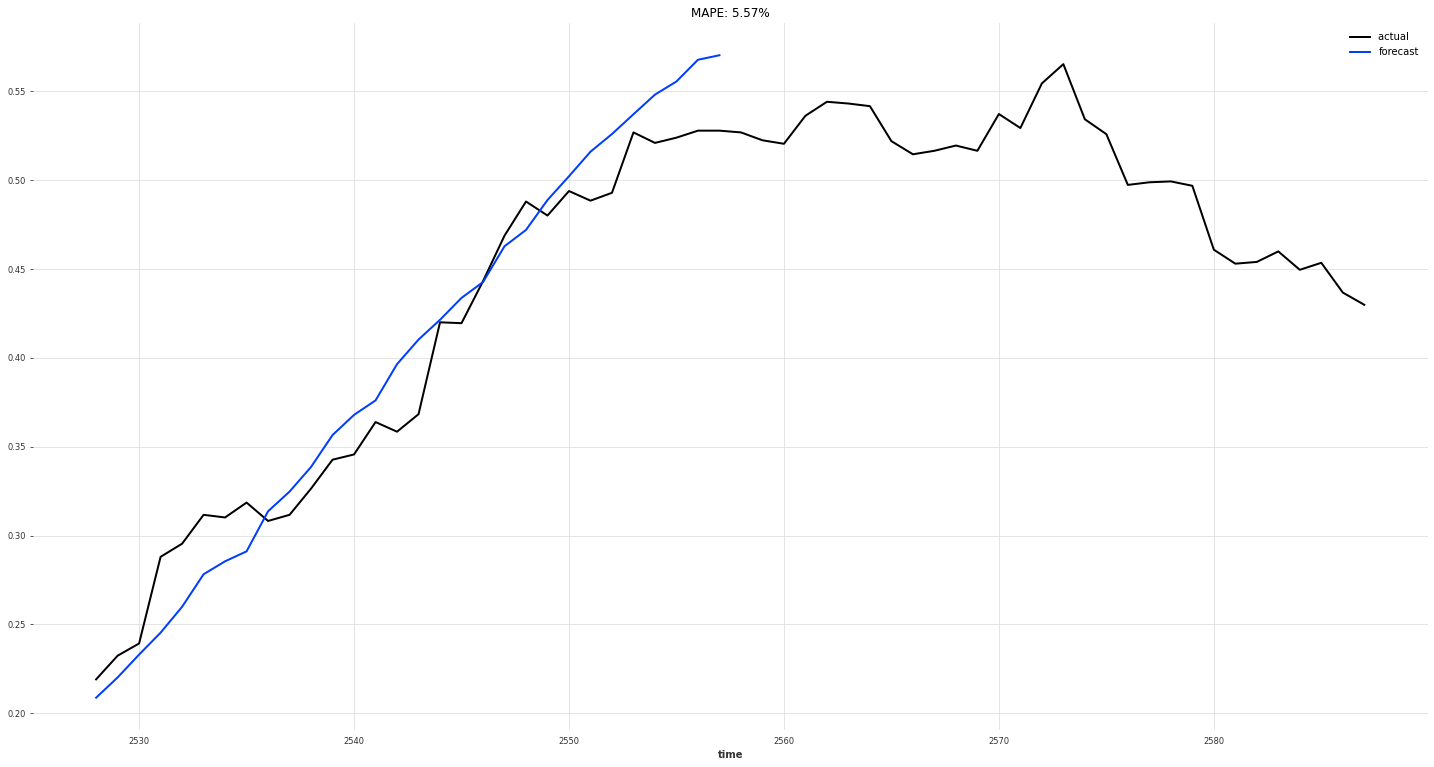

In [112]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('2_30min.png')


eval_model(my_model_, 30, val_scaled, val_scaled)

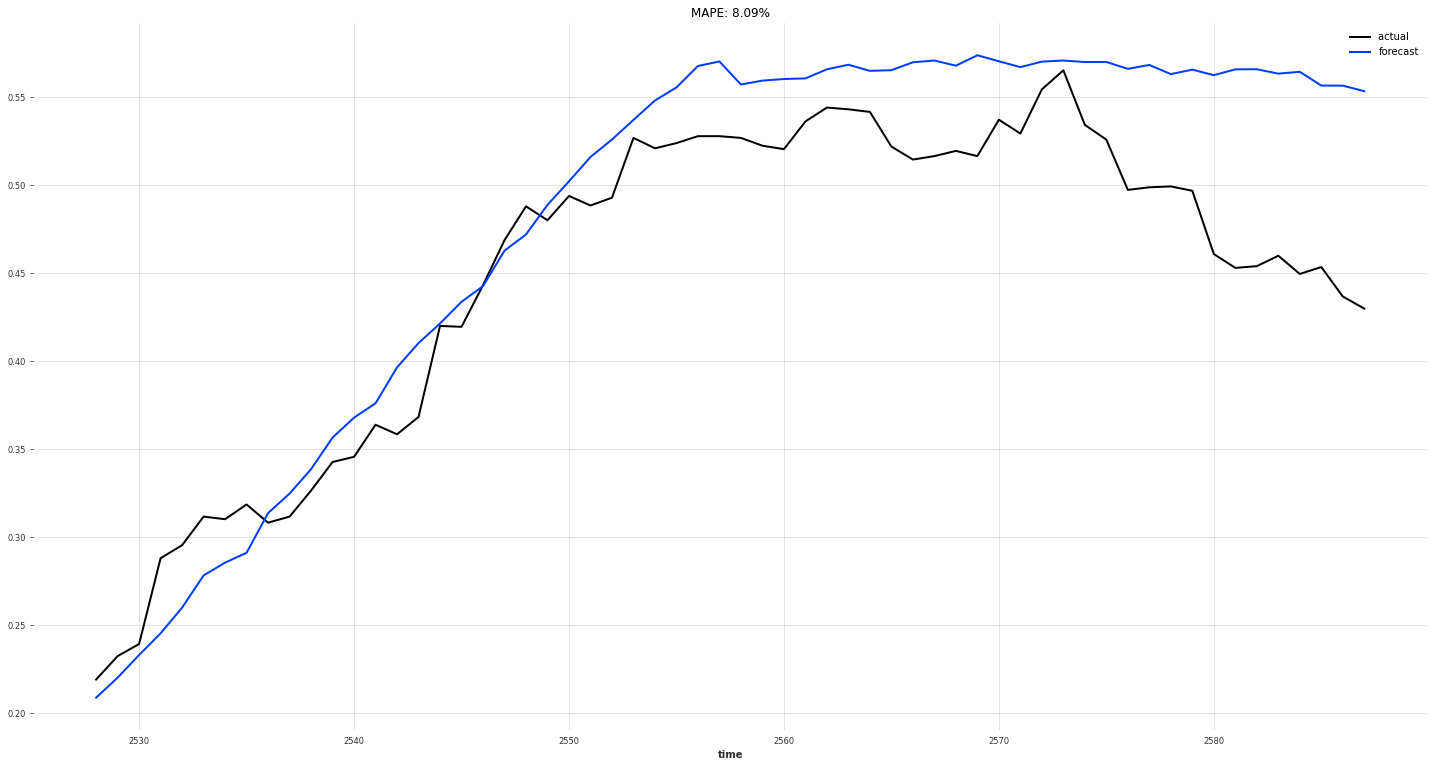

In [113]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(25, 13))
    series[:60].plot(label="actual ")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    #plt.title("MSE: {:.2f}%".format(rmse(pred_series, val_series)))
    plt.legend()
    plt.savefig('3_60min.png')


eval_model(my_model_, 60, val_scaled, val_scaled)

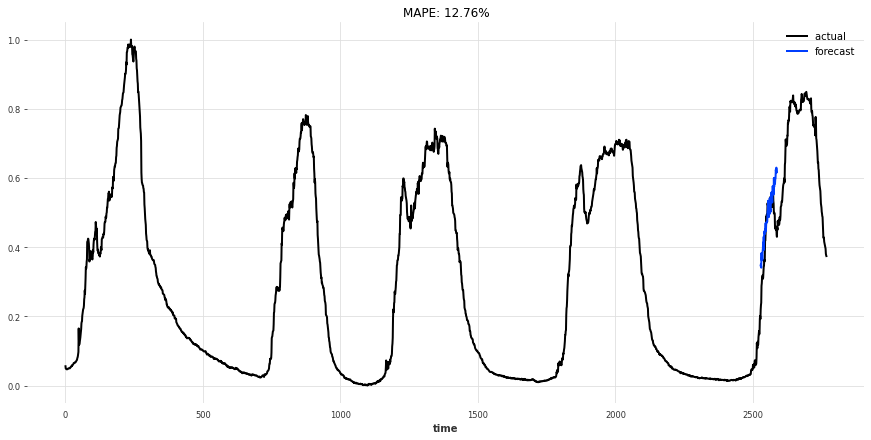

In [95]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="transformer_training", best=True
)
eval_model(best_model, 60, ts_scaled, val_scaled)

In [ ]:
# this function is used to backtest the model at a forecasting horizon of three years (36 months)
def backtest(testing_model):
    # Compute the backtest predictions with the two models
    pred_series = testing_model.historical_forecasts(
        series=ts_scaled,
        start=pd.Timestamp("19401001"),
        forecast_horizon=36,
        stride=10,
        retrain=False,
        verbose=True,
    )

    pred_series_ets = ExponentialSmoothing().historical_forecasts(
        series=series_sp_scaled,
        start=pd.Timestamp("19401001"),
        forecast_horizon=36,
        stride=10,
        retrain=True,
        verbose=True,
    )
    val_sp_scaled.plot(label="actual")
    pred_series.plot(label="our Transformer")
    pred_series_ets.plot(label="ETS")
    plt.legend()
    print("Transformer MAPE:", mape(pred_series, val_sp_scaled))
    print("ETS MAPE:", mape(pred_series_ets, val_sp_scaled))


best_model_sp = TransformerModel.load_from_checkpoint(
    model_name="co2_transformer", best=True
)
backtest(best_model_sp)